<a href="https://colab.research.google.com/github/cinmon/endo-detection/blob/main/FINAL_%5B%EC%98%81%EC%83%81%EC%9D%B4%ED%95%B4%5D_Endometriosys_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Endometryosis Detection

In [1]:
import matplotlib.pyplot as plt
from google.colab import files
import os, shutil
from sklearn.model_selection import train_test_split

In [2]:
!wget -O annotated_classes.zip https://ftp.itec.aau.at/datasets/GLENDA/downloads//Glenda_v1.5_classes.zip
!wget -O no_pathology.zip https://ftp.itec.aau.at/datasets/GLENDA/downloads/GLENDA_v1.5_no_pathology.zip

--2025-06-16 13:44:46--  https://ftp.itec.aau.at/datasets/GLENDA/downloads//Glenda_v1.5_classes.zip
Resolving ftp.itec.aau.at (ftp.itec.aau.at)... 143.205.173.53
Connecting to ftp.itec.aau.at (ftp.itec.aau.at)|143.205.173.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28009709 (27M) [application/zip]
Saving to: ‘annotated_classes.zip’

annotated_classes.z 100%[===================>]  26.71M  7.75MB/s    in 3.4s    

2025-06-16 13:44:51 (7.75 MB/s) - ‘annotated_classes.zip’ saved [28009709/28009709]

--2025-06-16 13:44:51--  https://ftp.itec.aau.at/datasets/GLENDA/downloads/GLENDA_v1.5_no_pathology.zip
Resolving ftp.itec.aau.at (ftp.itec.aau.at)... 143.205.173.53
Connecting to ftp.itec.aau.at (ftp.itec.aau.at)|143.205.173.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 867544435 (827M) [application/zip]
Saving to: ‘no_pathology.zip’

no_pathology.zip    100%[===================>] 827.35M  7.61MB/s    in 1m 41s  

2025-06-16 13:46

In [3]:
!unzip annotated_classes.zip
!unzip no_pathology.zip

Streaming output truncated to the last 5000 lines.
  inflating: no_pathology/frames/v_4044_s_0-253/f_27.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_28.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_29.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_3.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_30.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_31.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_32.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_33.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_34.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_35.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_36.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_37.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_38.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_39.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_4.jpg  
  inflating: no_pathology/frames/v_4044_s_0-253/f_40.jpg  
  infla

## Classification

In [4]:
# 2) Re-organize into train/validation folders for ImageDataGenerator

# original paths
pos_dir = 'Glenda_v1.5_classes/frames'
neg_dir = 'no_pathology/frames'

# new base
base_dir = 'data'
for split in ['train','validation']:
    for cls in ['positive','negative']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# collect all filepaths
pos_files = [os.path.join(dp, f) for dp,_,fs in os.walk(pos_dir) for f in fs if f.lower().endswith(('.jpg','.png'))]
neg_files = [os.path.join(dp, f) for dp,_,fs in os.walk(neg_dir) for f in fs if f.lower().endswith(('.jpg','.png'))]

# train/val split
pos_tr, pos_val = train_test_split(pos_files, test_size=0.2, random_state=42)
neg_tr, neg_val = train_test_split(neg_files, test_size=0.2, random_state=42)

# copy
for src_list, split, label in [
    (pos_tr, 'train','positive'),
    (pos_val,'validation','positive'),
    (neg_tr, 'train','negative'),
    (neg_val,'validation','negative'),
]:
    for src in src_list:
        dst = os.path.join(base_dir, split, label, os.path.basename(src))
        shutil.copy2(src, dst)

In [5]:
# 3) Classification pipeline with transfer learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
img_size = (224,224)
batch_size = 32

# data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.0  # we'll use separate dirs
)
train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir,'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir,'validation'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3560 images belonging to 2 classes.
Found 1855 images belonging to 2 classes.


In [7]:
# build model
base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*img_size,3))
base.trainable = False
clf = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])
clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# callbacks
callbacks = [
    ModelCheckpoint('best_classifier.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
]

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# train
clf_history = clf.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8858 - loss: 0.3535

112/112 ━━━━━━━━━━━━━━━━━━━━ 112s 789ms/step - accuracy: 0.8860 - loss: 0.3532 - val_accuracy: 0.9596 - val_loss: 0.2035
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 65s 585ms/step - accuracy: 0.9196 - loss: 0.2908 - val_accuracy: 0.9596 - val_loss: 0.2342
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9180 - loss: 0.2921

112/112 ━━━━━━━━━━━━━━━━━━━━ 67s 599ms/step - accuracy: 0.9180 - loss: 0.2922 - val_accuracy: 0.9596 - val_loss: 0.1930
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9072 - loss: 0.3224

112/112 ━━━━━━━━━━━━━━━━━━━━ 67s 597ms/step - accuracy: 0.9073 - loss: 0.3222 - val_accuracy: 0.9596 - val_loss: 0.1863
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9208 - loss: 0.2843

112/112 ━━━━━━━━━━━━━━━━━━━━ 67s 599ms/step - accuracy: 0.9207 - loss: 0.2844 - val_accuracy: 0.9596 - val_loss: 0.1707
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 65s 582ms/step - accuracy: 0.9145 - loss: 0.3080 - val_accuracy: 0.9596 - val_loss: 0.1752
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 65s 582ms/step - accuracy: 0.9195 - loss: 0.2928 - val_accuracy: 0.9596 - val_loss: 0.1801
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 66s 588ms/step - accuracy: 0.9108 - loss: 0.3132 - val_accuracy: 0.9596 - val_loss: 0.1711
Epoch 9/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 65s 586ms/step - accuracy: 0.9182 - loss: 0.2918 - val_accuracy: 0.9596 - val_loss: 0.1835
Epoch 10/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 67s 602ms/step - accuracy: 0.9141 - loss: 0.3035 - val_accuracy: 0.9596 - val_loss: 0.1813


I ended up with higher accuracy for validation than testing. This might be because of the data augmentation (makes it harder for tranining but more robust in validation).

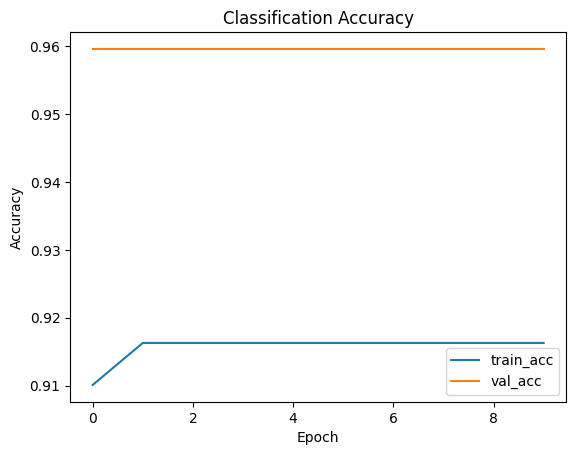

In [9]:
plt.figure()
plt.plot(clf_history.history['accuracy'], label='train_acc')
plt.plot(clf_history.history['val_accuracy'], label='val_acc')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Same thing, either:
- Validation is so easy that triaining is having a harder time due to data augmentation.
- The training examples are suffering from heavy augmentations (rotations, flips, etc.) that the network still hasn’t mastered.

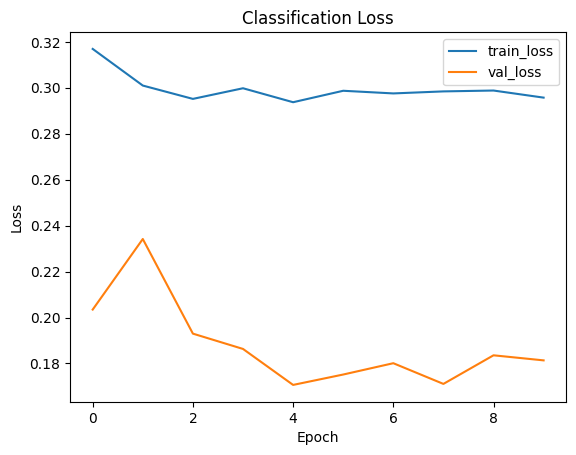

In [10]:
plt.figure()
plt.plot(clf_history.history['loss'], label='train_loss')
plt.plot(clf_history.history['val_loss'], label='val_loss')
plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 573ms/step


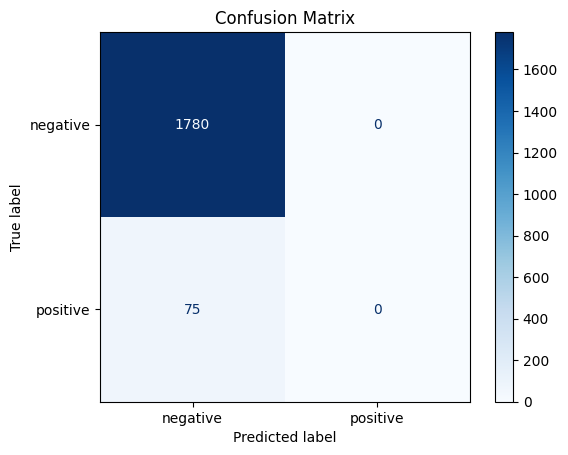

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay

# 1) Gather true labels & predicted probabilities
y_true = val_gen.classes                      # integer labels
y_prob = clf.predict(val_gen)[:, 1]           # prob of class “positive”
y_pred = (y_prob > 0.5).astype(int)

# 2) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=val_gen.class_indices.keys())
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

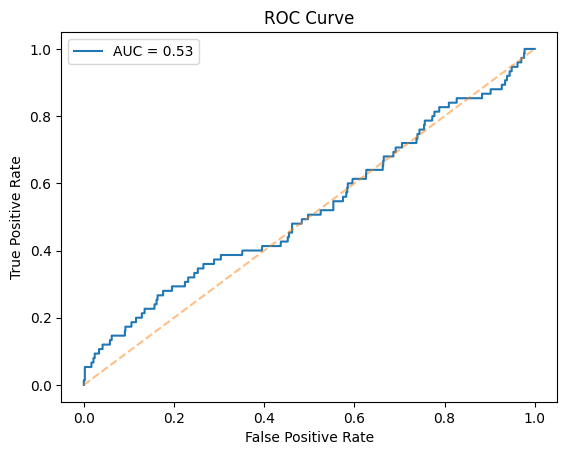

In [20]:
# 3) ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
# 4) Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_true, y_prob)
pr_display = PrecisionRecallDisplay(precision=prec, recall=rec)
pr_display.plot()
plt.title("Precision-Recall Curve")
plt.show()

## Segmentation

In [11]:
# 4) U-Net segmentation pipeline
import glob
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

# paths
img_paths  = sorted(glob.glob('Glenda_v1.5_classes/frames/**/*.jpg',  recursive=True))
mask_paths = sorted(glob.glob('Glenda_v1.5_classes/annots/**/*.png',  recursive=True))

# split
imgs_tr, imgs_val, msks_tr, msks_val = train_test_split(
    img_paths, mask_paths, test_size=0.2, random_state=42)

In [12]:
# helper funcs
def preprocess(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size) / 255.0
    m   = tf.io.read_file(mask_path)
    m   = tf.image.decode_png(m, channels=1)
    m   = tf.image.resize(m, img_size) / 255.0
    return img, m

train_ds = tf.data.Dataset.from_tensor_slices((imgs_tr, msks_tr)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(16).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((imgs_val, msks_val)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(16).prefetch(tf.data.AUTOTUNE)

In [13]:
# dice loss
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    inter  = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.*inter + smooth) / (tf.reduce_sum(y_true_f)+tf.reduce_sum(y_pred_f)+smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [14]:
# U-Net model
inputs = Input((*img_size,3))
c1 = Conv2D(64,3,activation='relu',padding='same')(inputs)
p1 = MaxPooling2D()(c1)

c2 = Conv2D(128,3,activation='relu',padding='same')(p1)
p2 = MaxPooling2D()(c2)

c3 = Conv2D(256,3,activation='relu',padding='same')(p2)

u2 = Conv2DTranspose(128,3,strides=2,padding='same')(c3)
u2 = concatenate([u2,c2])
c4 = Conv2D(128,3,activation='relu',padding='same')(u2)

u1 = Conv2DTranspose(64,3,strides=2,padding='same')(c4)
u1 = concatenate([u1,c1])
c5 = Conv2D(64,3,activation='relu',padding='same')(u1)

outputs = Conv2D(1,1,activation='sigmoid')(c5)
unet = Model(inputs, outputs)

unet.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])

# segmentation callbacks & train
seg_callbacks = [
    ModelCheckpoint('best_unet.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
]


In [15]:
seg_history = unet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=seg_callbacks
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef: 0.0713 - loss: 0.9287   

19/19 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - dice_coef: 0.0711 - loss: 0.9288 - val_dice_coef: 0.0705 - val_loss: 0.9298
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - dice_coef: 0.0753 - loss: 0.9246

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - dice_coef: 0.0752 - loss: 0.9247 - val_dice_coef: 0.0751 - val_loss: 0.9254
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - dice_coef: 0.0826 - loss: 0.9172 - val_dice_coef: 3.9950e-05 - val_loss: 1.0000
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - dice_coef: 3.6189e-05 - loss: 1.0000 - val_dice_coef: 3.9950e-05 - val_loss: 1.0000
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - dice_coef: 3.6189e-05 - loss: 1.0000 - val_dice_coef: 3.9950e-05 - val_loss: 1.0000
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - dice_coef: 3.6189e-05 - loss: 1.0000 - val_dice_coef: 3.9950e-05 - val_loss: 1.0000
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - dice_coef: 3.6189e-05 - loss: 1.0000 - val_dice_coef: 3.9950e-05 - val_loss: 1.0000


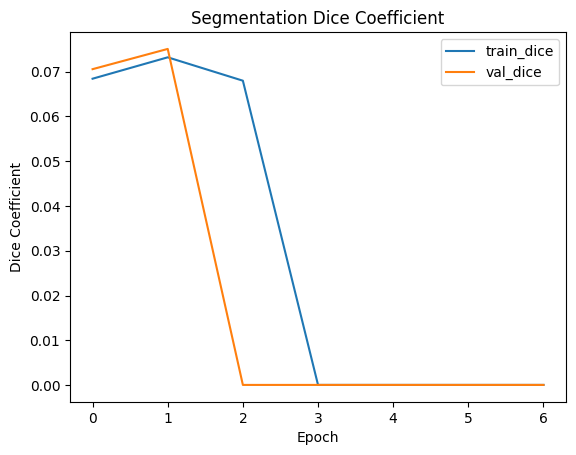

In [16]:
plt.figure()
plt.plot(seg_history.history['dice_coef'], label='train_dice')
plt.plot(seg_history.history['val_dice_coef'], label='val_dice')
plt.title('Segmentation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

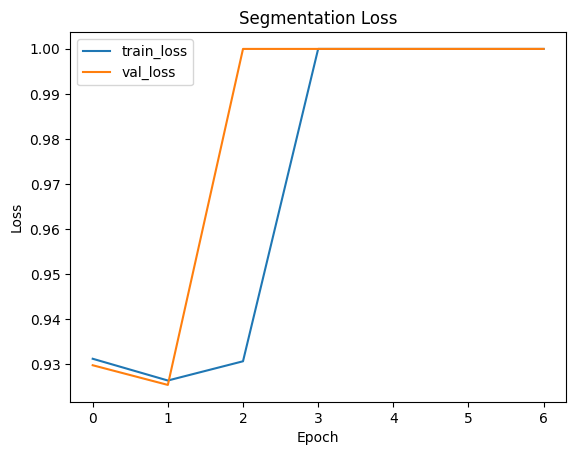

In [17]:
plt.figure()
plt.plot(seg_history.history['loss'], label='train_loss')
plt.plot(seg_history.history['val_loss'], label='val_loss')
plt.title('Segmentation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


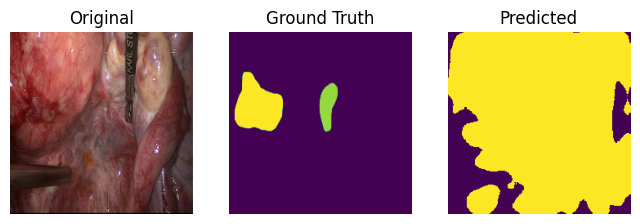

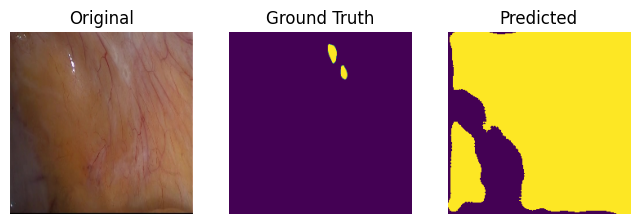

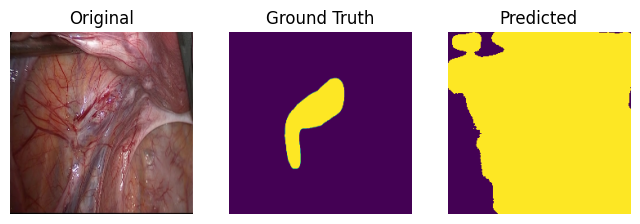

In [18]:
# --- Sample segmentation results ---
num_samples = 3
for images, masks in val_ds.take(1):
    preds = unet.predict(images)
    for i in range(num_samples):
        plt.figure(figsize=(8,4))
        # Original image
        plt.subplot(1,3,1)
        plt.imshow(images[i])
        plt.title('Original')
        plt.axis('off')
        # Ground truth mask
        plt.subplot(1,3,2)
        plt.imshow(masks[i].numpy().squeeze())
        plt.title('Ground Truth')
        plt.axis('off')
        # Predicted mask
        plt.subplot(1,3,3)
        plt.imshow(preds[i].squeeze() > 0.5)
        plt.title('Predicted')
        plt.axis('off')
        plt.show()